In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import cm
from io import StringIO
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [2]:
mangaid = '1-22948'
redshift = 0.119399
plateifu = '7992-9102'

In [3]:
# open the file
data = fits.open('/Users/natachaupra/Downloads/manga-7992-9102-LOGCUBE.fits.gz')

In [4]:
flux = np.transpose(data['FLUX'].data, axes=(2, 1, 0))
ivar = np.transpose(data['IVAR'].data, axes=(2, 1, 0))
mask = np.transpose(data['MASK'].data, axes=(2, 1, 0))
wave = data['WAVE'].data

do_not_use = (mask & 2**10) != 0

In [5]:
oii3727 = np.where(np.logical_and(wave > 4160, wave < 4180))
oiii4959 = np.where(np.logical_and(wave > 5545, wave < 5560)) 
oiii5007 = np.where(np.logical_and(wave > 5590, wave < 5620)) 
hbeta4861 = np.where(np.logical_and(wave > 5420, wave < 5460))
# oii3727, oiii4959, oiii5007, hbeta4861

In [6]:
# Range for x in gaussian

oii3727_range = (634, 653)
oiii4959_range = (1878, 1885)
oiii5007_range = (1917, 1931)
hbeta4861_range = (1783, 1806)

In [7]:
def sigma_gen_compare(array, flux_masked):
    
    # change ivar array to sigma array 
    
    sigma = np.sqrt(np.abs(np.divide(1, array, where = array != 0)))
#     print(sigma)
    
    is_less_than_3sigma = flux_masked < 3 * sigma # compare the sigma array 
#     print(flux_masked)
#     print(is_less_than_3sigma)
        
    flux_masked_filtered = flux_masked * ~is_less_than_3sigma # multiply the truth value
    
    return flux_masked_filtered

In [8]:
def gaussian(x, amp, mean, sigma, base):
    return (amp * np.exp(-(x-mean)**2 / (2*sigma**2))) + base

In [9]:
oiix = wave[oii3727_range[0] : oii3727_range[-1]]
# print('oiix', oiix)
# print('oiiy', oiiy)

oiiix1 = wave[oiii4959_range[0] : oiii4959_range[-1]]

oiiix2 = wave[oiii5007_range[0] : oiii5007_range[-1]]

hbetax = wave[hbeta4861_range[0] : hbeta4861_range[-1]]

In [10]:
def area_finder(x, y):
#     print('x',x)
#     print('y',y)
    dlmd = (x[-1] - x[0])/len(x)
#     print(dlmd)
        
    area = (1/2)*(dlmd)*(y[0] + y[-1] + np.sum(2*(y[1:-1])))
#     print('area', area)

    subtract = y[0] * (x[-1] - x[0])

    subtracted_area = area - subtract
#     print(subtracted_area)
    
    return subtracted_area

Change the method below to gaussian

In [11]:
to_plot = []
to_plot_wo_hbeta = []

for i in range(len(flux)):
    
    res = [] 
    res_wo_hbeta = []
    
    for j in range(len(flux[0])):

        flux_masked = flux[i,j] * ~do_not_use[i,j] # masking the array
        
        flux_masked_filtered = sigma_gen_compare(ivar[i,j], flux_masked) 
        
        oiiy = flux_masked_filtered[oii3727_range[0] : oii3727_range[-1]]
        oii_subtracted_area = area_finder(oiix, oiiy)
        
        oiiiy1 = flux_masked_filtered[oiii4959_range[0] : oiii4959_range[-1]]
        oiii1_subtracted_area = area_finder(oiiix1, oiiiy1)

        oiiiy2 = flux_masked_filtered[oiii5007_range[0] : oiii5007_range[-1]]
        oiii2_subtracted_area = area_finder(oiiix1, oiiiy2)
        
        hbetay = flux_masked_filtered[hbeta4861_range[0] : hbeta4861_range[-1]]
        hbeta_subtracted_area = area_finder(hbetax, hbetay)

        if(hbeta_subtracted_area != 0):
            r23 = (oii_subtracted_area + oiii1_subtracted_area + oiii2_subtracted_area)/hbeta_subtracted_area
            
            if r23 > 0:
                metallicity = 6.486 + (1.401 * np.log10(r23))
                res.append(metallicity)
            else:
                res.append(0)
                
        else:
            res.append(0)
            
    to_plot.append(res)
    to_plot_wo_hbeta.append(res_wo_hbeta)

In [12]:
# to_plot = np.ma.masked_where(to_plot == 0, to_plot, 'dtype = object')

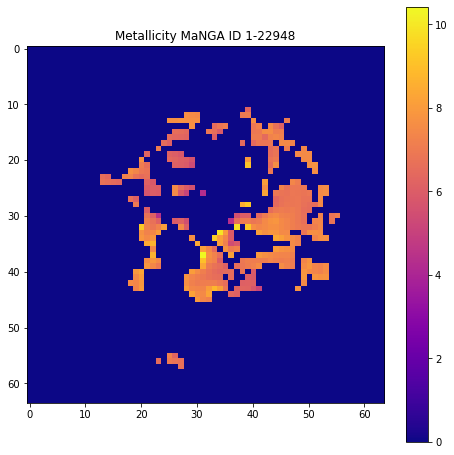

In [13]:
# print(to_plot)
plt.figure(figsize = (8,8))
plt.imshow(to_plot, cmap = cm.plasma)
# plt.imshow(to_plot, cmap = cm.plasma)
plt.title(f'Metallicity MaNGA ID {mangaid}')
plt.colorbar()
# plt.savefig('/Users/natachaupra/Desktop/Snr_Prj/Metallicity/Images/metallicity_{}'.format(mangaid),
#             bbox_inches = 'tight')

In [16]:
def distance(x, y):
    return np.sqrt((x-(len(to_plot)/2))**2 + (y-(len(to_plot)/2))**2)

In [17]:
bin_size = 1
bin_list = []
lst = [] 
for i in range(len(to_plot)):
    for j in range(len(to_plot[0])):
        lst.append(int(np.round(distance(i, j) / bin_size) * bin_size))
    bin_list.append(lst)
    lst = []

In [19]:
# fig = plt.figure(figsize=(15,15))
# ax = fig.gca()
# ax.set_xticks(np.arange(0, len(to_plot), 1))
# ax.set_yticks(np.arange(0, len(to_plot), 1))
# plt.imshow(bin_list, cmap='Wistia')
# plt.grid()
# plt.colorbar()

# for (i, j), z in np.ndenumerate(bin_list):
#     ax.text(j, i, '{}'.format(z), ha='center', va='center')
    
# plt.show()

In [21]:
met_trend = dict()
counter = dict()
for i in range(len(bin_list)):
    for j in range(len(bin_list)):
        if bin_list[i][j] in met_trend:
            met_trend[bin_list[i][j]] += to_plot[i][j]
            counter[bin_list[i][j]] += 1
        else:
            met_trend[bin_list[i][j]] = to_plot[i][j]
            counter[bin_list[i][j]] = 1
            
# met_trend, counter

In [23]:
dist = []
sum_met = []
for i in met_trend:
    dist.append(i)
    if i != 0:
        sum_met.append(met_trend[i]/counter[i])
    else:
        sum_met.append(met_trend[i])

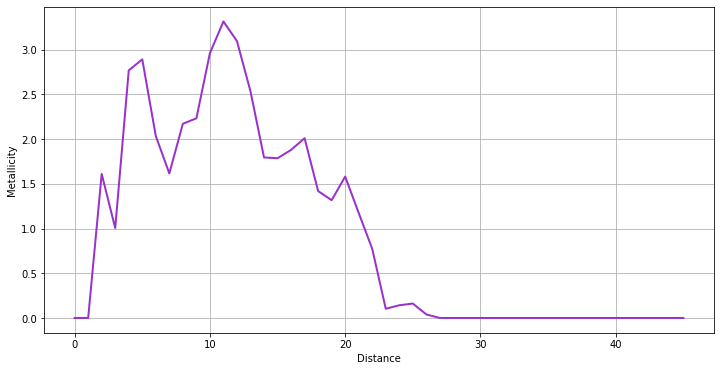

In [25]:
plt.figure(figsize = (12,6))
plt.grid()
plt.xlabel('Distance')
plt.ylabel('Metallicity')
plt.plot(dist, sum_met, color = 'darkorchid', linewidth = 2)